Apostolos Tamvakis <br>
Loukas Gravias

## Pre-processing

In [0]:
import nltk
import math
from pprint import pprint

In [0]:
nltk.download('gutenberg')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
sentences = nltk.corpus.gutenberg.sents('austen-emma.txt')

[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Unzipping corpora/gutenberg.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


Get rid of stopwords and lemmatize words in train dev and test

In [0]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
cleaned_dataset = []
for sentence in sentences:
    filtered_sentence = [w for w in sentence if w not in stopwords.words('english')]
    lemmas_sentence = [ lemmatizer.lemmatize(word) for word in filtered_sentence ]
    cleaned_dataset.append(lemmas_sentence)
cleaned_dataset[:2]

[['[', 'Emma', 'Jane', 'Austen', '1816', ']'], ['VOLUME', 'I']]

Split Dataset

In [0]:
total_sents = len(cleaned_dataset)

train_sentences = cleaned_dataset[0:round(total_sents*0.7)]
dev_sentences = cleaned_dataset[round(total_sents*0.7):round(total_sents*0.8)]
test_sentences = cleaned_dataset[round(total_sents*0.8):round(total_sents)]

Turn sentences to words

In [0]:
train_words = []
dev_words = []
test_words = []
for i in train_sentences:
    train_words += i

for i in dev_sentences:
    dev_words += i

for i in test_sentences:
    test_words += i
test_words[0:10]

['They',
 'combined',
 'anger',
 ',',
 'mortification',
 ',',
 'deep',
 'concern',
 '.',
 'She']

## Get word frequency

In [0]:
count = nltk.FreqDist(train_words)
pprint(count.most_common(10))

[(',', 7624),
 ('.', 4926),
 ('I', 2133),
 (';', 1558),
 ('"', 1386),
 ('--', 894),
 ('Mr', 846),
 ('."', 832),
 ("'", 692),
 ('would', 558)]


### Replace all out-of-vocabular (OOV) words (in the training, development, test subsets) by a special token *UNK*

In [0]:
keeping_words = {} # keep words that occur at least 10 times
for word in count.keys():
    if count[word] >= 10:
        keeping_words[word] = count[word]
len(keeping_words)

994

In [0]:
filter_words=list(keeping_words.keys())

mapping = nltk.defaultdict(lambda: 'UNK')

for v in filter_words:
    mapping[v]=v

cleared_train_sentences = []
cleared_test_sentences = []
cleared_dev_sentences = []

for sentence in train_sentences:
    cleared_sentence=[mapping[v] for v in sentence]
    cleared_train_sentences.append(cleared_sentence)

for sentence in dev_sentences:
    cleared_sentence=[mapping[v] for v in sentence]
    cleared_dev_sentences.append(cleared_sentence)

for sentence in test_sentences:
    cleared_sentence=[mapping[v] for v in sentence]
    cleared_test_sentences.append(cleared_sentence)

## Create and count n-grams frequency

In [0]:
from collections import Counter
from nltk.util import ngrams

unigram_counter = Counter()
bigram_counter = Counter()
trigram_counter = Counter()

for sent in cleared_train_sentences:
    
    unigram_counter.update([gram for gram in ngrams(sent, 1, pad_left=True, pad_right=True,
                                                   left_pad_symbol='<s>',right_pad_symbol='<e>') ])
    bigram_counter.update([gram for gram in ngrams(sent, 2, pad_left=True, pad_right=True,
                                                   left_pad_symbol='<s>',right_pad_symbol='<e>') ])
    trigram_counter.update([gram for gram in ngrams(sent, 3, pad_left=True, pad_right=True,
                                                   left_pad_symbol='<s>',right_pad_symbol='<e>') ])
pprint(unigram_counter)   
pprint(bigram_counter)
pprint(trigram_counter)

Output hidden; open in https://colab.research.google.com to view.

##  Calculate bi-gram robability with a smoothing

### $ P(w_2|w_1) = \frac{C(w_1,w_2) + \alpha}{C(w_1) + \alpha \cdot|V|} $

* $ C(w_1,w_2) $ : bigram count
* $ C(w_1) $ : unigram count
* $ 0 \leq\alpha \leq1 $ :  smoothing hyper-parameter 
* |V|: vocabulary size

In [0]:
alpha=0.01 #not fine tuned yet
vocab_size=len(filter_words)

In [0]:
def bigram_log_prob(bigram,alpha):
    # len(filter_words) is our vocab size
    prob = (bigram_counter[(bigram[0],bigram[1])] +alpha)/(unigram_counter[(bigram[0],)]+alpha*vocab_size)
    return math.log2(prob)

## Tri-gram Probability with a smoothing

### $ P(w_3|w_1,w_2) = \frac{C(w_1,w_2,w_3) + \alpha}{C(w_1,w_2) + \alpha \cdot |V|} $

* $ C(w_1,w_2,w_3) $ : trigram count
* $ C(w_1,w_2) $ : bigram count
* $ 0 \leq\alpha \leq1 $ :  smoothing hyper-parameter 
* |V|: vocabulary size

In [0]:
def trigram_log_prob(trigram,alpha):
    prob = (trigram_counter[(trigram[0],trigram[1],trigram[2])] +alpha)/(bigram_counter[(trigram[0],trigram[1])]+alpha*vocab_size)
    return math.log2(prob)

## Calculate ngram sentence log-probability

In [0]:
def calculate_bigram_sentence_prob(sent,alpha):
    sum_prob = 0
    bigram_cnt = 0
    sent = ['<s>'] + sent + ['<e>']
    for idx in range(1,len(sent)):
        sum_prob += bigram_log_prob([sent[idx-1], sent[idx]],alpha)
        bigram_cnt+=1
    return sum_prob, bigram_cnt


def calculate_trigram_sentence_prob(sent,alpha):
    sum_prob = 0
    trigram_cnt = 0
    sent = ['<s>'] + ['<s>'] + sent + ['<e>'] + ['<e>']
    for idx in range(2,len(sent)):
        sum_prob += trigram_log_prob([sent[idx-2],sent[idx-1], sent[idx]],alpha)
        trigram_cnt+=1
    return sum_prob, trigram_cnt

## ii)  
### Compare the log-probabilities that your trained models return when given (correct) example sentences from the test subset vs. (incorrect) sentences of the same length (in words) consisting of randomly selected vocabulary words.

Create a random sentece from the vocabuary that has the same length as a test sentence in this case cleared_test_sentences[10]

In [0]:
import random

def create_random_sentece(sent_length, vocab):
    word_list = []
    for i in sent_length:
      random_word = random.choice(list(vocab.keys()))
      word_list.append(random_word)

    return word_list
  
random_sentence = create_random_sentece(cleared_test_sentences[10], keeping_words)
print(random_sentence)

['early', 'Highbury', 'obliged', 'gratified', 'effect', 'My', 'judge', 'form']


In [0]:
print("The bigram log-probability of the random sentence is: ",calculate_bigram_sentence_prob(random_sentence,alpha)[0])
print("The trigram log-probability of the random sentence is: ", calculate_trigram_sentence_prob(random_sentence,alpha)[0])

The bigram log-probability of the random sentence is:  -105.92820855016421
The trigram log-probability of the random sentence is:  -99.57102041562285


In [0]:
cleared_test_sentences[10]

['How', 'could', 'UNK', 'ill', 'opinion', 'one', 'UNK', '!']

In [0]:
print("The bigram log-probability of the real sentence is: ", calculate_bigram_sentence_prob(cleared_test_sentences[10],alpha)[0])
print("The trigram log-probability of the real sentence is: ", calculate_trigram_sentence_prob(cleared_test_sentences[10],alpha)[0])

The bigram log-probability of the real sentence is:  -36.984967920252224
The trigram log-probability of the real sentence is:  -56.16879970859484


## iii)
##### Estimate the language cross-entropy and perplexity of your models on a test subset of the corpus, treating the entire test subset as a single sequence, with *start* (or *start1*, *start2*) at the beginning of each sentence, and *end* at the end of each sentence. Do not include probabilities of the form P(*start*|…) (or P(*start1*|…) or P(*start2*|…)) in the computation of cross-entropy and perplexity, but include probabilities of the form P(*end*|…). You must also count *end* tokens (but not *start*, *start1*, *start2* tokens) in the total length N of the test corpus.

In [0]:
def corpus_bi_HC(corpus,alpha):
    sum_prob = 0
    bigram_cnt = 0
    for sentence in corpus:
        
        sent_prob, sent_cnt = calculate_bigram_sentence_prob(sentence,alpha)
        sum_prob += sent_prob
        bigram_cnt += sent_cnt
#       print("bigram_lm_prob_in_corpus = ",sum_prob)
    HC = -sum_prob / bigram_cnt
    perpl = math.pow(2,HC)
    return HC, perpl

def corpus_tri_HC(corpus,alpha):
    sum_prob = 0
    trigram_cnt = 0
    for sentence in corpus:
        sent_prob, sent_cnt = calculate_trigram_sentence_prob(sentence,alpha)
        sum_prob += sent_prob
        trigram_cnt += sent_cnt
#       print("trigram_lm_prob_in_corpus = ",sum_prob)
    HC = -sum_prob / trigram_cnt
    perpl = math.pow(2,HC)
    return HC, perpl

### fine tune alpha on dev set

In [0]:
import pandas as pd
import numpy as np

In [0]:
df = pd.DataFrame({'alpha': [],'Cross-Entropy_bi':[], 'Perplexity_bi': [],'Cross-Entropy_tri':[], 'Perplexity_tri': []})
for alpha in np.arange(0.001,1.05,0.005):
    res_bi=corpus_bi_HC(dev_sentences,alpha)
    res_tri=corpus_tri_HC(dev_sentences,alpha)
    df = df.append({'alpha':alpha,'Cross-Entropy_bi':round(res_bi[0],3),'Perplexity_bi':round(res_bi[1],3),'Cross-Entropy_tri':round(res_tri[0],3),'Perplexity_tri':round(res_tri[1],3)}, ignore_index=True)
   

In [0]:
from matplotlib import pyplot as plt

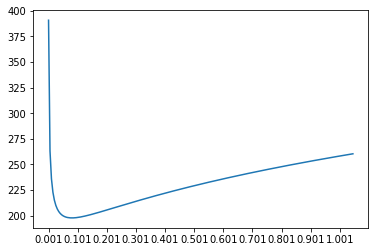

In [0]:
plt.plot(df['alpha'],df['Perplexity_bi'])
plt.xticks(np.arange(min(df['alpha']), max(df['alpha']), 0.1));


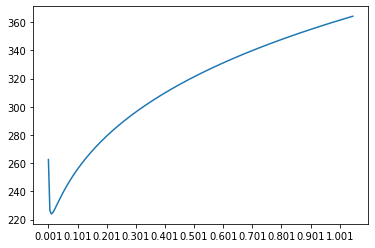

In [0]:
plt.plot(df['alpha'],df['Perplexity_tri'])
plt.xticks(np.arange(min(df['alpha']), max(df['alpha']), 0.1));

In [0]:
print('Min alpha_bi {}, Min alpha_tri {}'.format(df['alpha'].iloc[df['Cross-Entropy_bi'].idxmin()],df['alpha'].iloc[df['Cross-Entropy_tri'].idxmin()]))

Min alpha_bi 0.076, Min alpha_tri 0.011


In [0]:
alpha_bi=df['alpha'].iloc[df['Cross-Entropy_bi'].idxmin()]
alpha_tri=df['alpha'].iloc[df['Cross-Entropy_tri'].idxmin()]


### Estimation of language cross-entropy and perplexity of the language models on a test subset of the corpus

In [0]:
corpus_bi_HC(cleared_test_sentences,alpha_bi)

(5.932350741208574, 61.068256056629025)

In [0]:
corpus_tri_HC(cleared_test_sentences,alpha_tri)

(6.7508063063134935, 107.69491383306877)

# iv) 
### Combine your two models using linear interpolation and check if the combined model performs better in terms of cross-entropy and perplexity. Tune the λ hyper-parameters on a development subset of the corpus.

In [0]:
lamda = 0.6 # set an initial hyperparameter
def interpolated_LM(corpus,lamda,alpha_bi,alpha_tri):
    sum_prob = 0
    ngram_cnt = 0
    for sent in corpus:
        sent = ['<s>'] + ['<s>'] + sent + ['<e>'] + ['<e>']
        for idx in range(2,len(sent)):
            bigram_prob= bigram_log_prob([sent[idx-1], sent[idx]],alpha_bi)
            trigram_prob=trigram_log_prob([sent[idx-2],sent[idx-1], sent[idx]],alpha_tri)
            sum_prob += (lamda * trigram_prob) +((1-lamda) * bigram_prob)
            ngram_cnt+=1 
    
    HC = -sum_prob / ngram_cnt
    perpl = math.pow(2,HC)
    return HC, perpl

In [0]:
interpolated_LM(cleared_test_sentences,lamda,alpha_bi,alpha_tri)
interpolated_LM(cleared_test_sentences,lamda,alpha_bi,alpha_tri)

(6.510576420527741, 91.17563394326635)

### Fine tune lamda on dev set

In [0]:
df = pd.DataFrame({'lamda': [],'Cross-Entropy':[], 'Perplexity': []})
for lamda in np.arange(0,1.05,0.05):
    res=interpolated_LM(dev_sentences,lamda,alpha_bi,alpha_tri)
    df = df.append({'lamda': round(lamda,2),'Cross-Entropy':res[0],  'Perplexity': res[1]}, ignore_index=True)
    

* λ=0 represents the bigram language model
* λ=1 represents the triigram language model

In [0]:
df

,lamda,Cross-Entropy,Perplexity
0,0.00,7.782011,220.099347
1,0.05,7.783281,220.293129
2,0.10,7.784550,220.487082
3,0.15,7.785820,220.681206
4,0.20,7.787090,220.875500
5,0.25,7.788359,221.069966
6,0.30,7.789629,221.264603
7,0.35,7.790898,221.459411
8,0.40,7.792168,221.654390
9,0.45,7.793438,221.849542


Text(0, 0.5, 'Cross-Entropy')

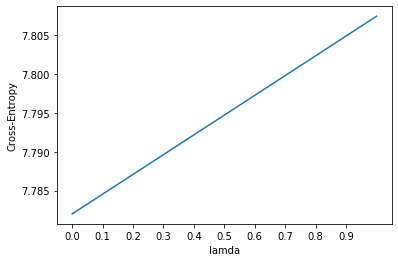

In [0]:
plt.plot(df['lamda'],df['Cross-Entropy'])
plt.xticks(np.arange(min(df['lamda']), max(df['lamda']), 0.1));
plt.xlabel('lamda')
plt.ylabel('Cross-Entropy')